In [2]:
# Draft pour le rendu final 

# Datasets à utiliser: users.csv, beers.csv, reviews.txt.gz 
# (on se focus que sur 1 site pour le moment, à savoir beeradvocate/ratebeer?)

#beers.csv
# print les 5 premières lignes
# d'où viennent les bières par continent 
# 14 catégories faites par le site lui même https://www.beeradvocate.com/beer/styles/ + 1 "weird cocktail"
# combien de bières ont été ratées par nos valid users (après partie filtre rating maybe)

#users.csv
# print les 5 premières lignes
# on regarde le pourcentage des US. Hypothèse: les américains ont accès aux mêmes bières
# discussion autour des valid users -> combien de ratings

# reviews.txt.gz
# d'abord print des exemples de reviews entières (avec le texte etc.)
# Mentionner que le data-set est immense
# Expliquer comment on a loadé les données et les colonnes qu'on a drop pour 
# qu'on puisse gérer le dataset
# Ajoute les ratings, leur temporalité et tous les ratings détaillés (en gros 
# ce que ce que dataset nous apporte)
# Plot de Pale
# Plot de Maxime

# Pour répondre a notre question:
# Métrique de la validité
# Plot de Pale 
# Approche avec les Graphes: on explique la construction pour un user, la construction
# du graphe final, les différentes manières de construire les weights,  
# "Algorithme de Louvain" -> lots of mathematical details (une mesure de clustering)



In [3]:
#ICI CA PARLE souvent de df_ratings_99 ... il est def ou ? et on l'utilise ou èas ???

In [72]:
import pandas as pd
import seaborn as sns
import datetime
import sys
import gzip
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

### 

In the datatsets we have there is 3 different datasets : users.csv, beers.csv, reviews.txt.gz for 2 websites. We first focus on beeradvocate website.

## Dataset beers.csv

First of all, we look the "beers.csv" in more details

In [53]:
#load the data beers.csv
df_beers = pd.read_csv('./data/beers.csv')

In [54]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [57]:
print(df_beers.shape)

(280823, 9)


count    280823.000000
mean         29.887267
std         231.010063
min           0.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       16509.000000
Name: nbr_ratings, dtype: float64

We have a total of  280823 beers with 15 variables

For the following, we will consider these variables:

- beer_id and beer_name : the ID and name of the beer

- brewery id and name : the ID and name of the brewery where the considered beers comes from

- style: this variable indicates the category of the beer. There are many different categories and we will explain later how we manage to reduce this number.

- nbr_reviews and nbr_ratings : the number of reviews and ratings respectively for a given beer

- avg : it corresponds to the average ratings for a given beer

- abv : the alcohol by volume percentage

- The other columns are a variety of scores computed for the beer, which we will not use

In [56]:
list_considered_variable=['beer_id','beer_name','brewery_id','brewery_name','style','nbr_reviews','nbr_ratings','avg', 'abv']
df_beers=df_beers[list_considered_variable]

In [68]:
df_beers['nbr_ratings'].describe()

count    280823.000000
mean         29.887267
std         231.010063
min           0.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       16509.000000
Name: nbr_ratings, dtype: float64

We observe that 75% of the beers have at most 8 ratings. After this observation, we decided that it might be a good idea to group the beers into categories since we don't want to remove the 75% percent of the beers we have. To do so, we decided to create a variable 'category'. We decided to used the 14 categories for the style made in https://www.beeradvocate.com/beer/styles/.  We also added the category 'Weird cocktail' as this category does not exist anymore.

We create here a dict to map one sub-category to its parent, and vice-versa.

In [9]:
beer_catalog = {
    'Bocks' : ['Bock', 'Doppelbock', 'Eisbock', 'Maibock', 'Weizenbock', 'Maibock / Helles Bock'],

    'Dark Ales' : ['Dubbel', 'Roggenbier', 'Scottish Ale', 'Winter Warmer'],

    'Hybrid Beers' : ['Bière de Champagne / Bière Brut', 'Braggot', 'California Common / Steam Beer', 'Cream Ale'],

    'Pale Ales' : ['American Amber / Red Ale', 'American Blonde Ale', 'American Pale Ale', 'Belgian Blonde Ale',
    'Belgian Pale Ale', 'Bière de Garde', 'English Bitter', 'English Pale Ale', 'English Pale Mild Ale', 'Extra Special / Strong Bitter (ESB)',
    'Grisette', 'Irish Red Ale', 'Kölsch', 'Saison', 'Saison / Farmhouse Ale', 'Belgian Strong Pale Ale', 'American Pale Ale (APA)'],

    'Porters' : ['American Porter', 'Baltic Porter', 'English Porter', 'Imperial Porter', 'Robust Porter ', 'Smoked Porter'],

    'Stouts' : ['American Imperial Stout', 'American Stout', 'English Stout', 'Foreign / Export Stout', 'Irish Dry Stout', 'Oatmeal Stout',
    'Russian Imperial Stout', 'Milk / Sweet Stout', 'American Double / Imperial Stout'],

    'Wheat Beers' : ['American Dark Wheat Beer', 'American Pale Wheat Beer', 'Dunkelweizen', 'Grodziskie', 'Hefeweizen', 'Kristallweizen', 'Witbier', 
    'American Pale Wheat Ale', 'American Dark Wheat Ale', 'Berliner Weissbier', 'Kristalweizen'],

    'Brown Ales' : ['Altbier', 'American Brown Ale', 'Belgian Dark Ale', 'English Brown Ale', 'English Dark Mild Ale', 'Belgian Strong Dark Ale'],

    'Dark Lagers' : ['American Amber / Red Lager', 'Czech Amber Lager', 'Czech Dark Lager', 'European Dark Lager', 'Märzen',
    'Munich Dunkel', 'Rauchbier', 'Schwarzbier', 'Vienna Lager', 'Munich Dunkel Lager', 'Euro Dark Lager'],

    'India Pale Ales' : ['American IPA', 'American Double / Imperial IPA', 'Belgian IPA', 'Black IPA', 'Brut IPA', 'English IPA', 'English India Pale Ale (IPA)', 
    'Imperial IPA', 'Milkshake IPA', 'New England IPA', 'American Black Ale'],

    'Pale Lagers' : ['American Adjunct Lager', 'American Lager', 'Bohemian / Czech Pilsner', 'Czech Pale Lager', 'European / Dortmunder Export Lager',
    'European Pale Lager', 'European Strong Lager', 'Festbier / Wiesnbier', 'German Pilsner', 'Helles', 'Imperial Pilsner', 'India Pale Lager (IPL)',
    'Kellerbier / Zwickelbier', 'Light Lager', 'Malt Liquor', 'Czech Pilsener', 'Euro Pale Lager', 'American Pale Lager', 'German Pilsener', 'Dortmunder / Export Lager', 
    'Euro Strong Lager', 'Munich Helles Lager', 'American Double / Imperial Pilsner', 'American Malt Liquor', 'Märzen / Oktoberfest'],

    'Specialty Beer' : ['Chile Beer', 'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale', 'Happoshu', 'Herb and Spice Beer', 'Japanese Rice Lager',
    'Kvass', 'Low-Alcohol Beer', 'Pumpkin Beer', 'Rye Beer', 'Sahti', 'Smoked Beer', 'Herbed / Spiced Beer', 'Pumpkin Ale', 'Scottish Gruit / Ancient Herbed Ale', 'Low Alcohol Beer'],

    'Strong Ales' : ['American Barleywine', 'American Strong Ale', 'Belgian Dark Strong Ale', 'Belgian Pale Strong Ale', 'English Barleywine', 'English Strong Ale',
    'Imperial Red Ale', 'Old Ale', 'Quadrupel (Quad)', 'Scotch Ale / Wee Heavy', 'Tripel', 'Wheatwine', 'Fruit / Vegetable Beer'],
    
    'Wild/Sour Beers' : ['Berliner Weisse', 'Brett Beer', 'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale', 'Fruit Lambic',
    'Fruited Kettle Sour', 'Gose', 'Gueuze', 'Lambic', 'Wild Ale', 'Lambic - Unblended', 'Lambic - Fruit', 'American Wild Ale'],

    'Weird Cocktail' : ['Black & Tan']
}

In [10]:
beer_catalog_reverse = {}
for key, values in beer_catalog.items():
    for value in values:
            beer_catalog_reverse.setdefault(value, []).append(key)

Here, we create a function to map the sub-category to its parent, and then apply it to the dataset.

In [11]:
def category_check(beer_style, beer_catalog):
    '''
    Return the new columns of 15 categories made in the website https://www.beeradvocate.com/beer/styles/
    '''
    for category_name, beer_styles in beer_catalog.items():
        if beer_style in beer_styles:
            return category_name

In [70]:
df_beers['category'] = df_beers['style'].apply(lambda beer_style: category_check(beer_style, beer_catalog))

In [13]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,category
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN,Pale Lagers
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN,Pale Lagers
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN,Pale Lagers
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN,Pale Lagers
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN,Pale Lagers


We want now to investigate how the categories we created are represented

In [80]:
#REDONDANCE SIZE AND Y

#Create new data frame for the plot 
cat=df_beers.groupby('category').count()["beer_id"]
cat=cat.reset_index()
cat = cat.sort_values(by=['beer_id'], ascending=True)
cat=cat.reset_index()
#normalize to have a percentage per category 
cat["beer_id"] = cat["beer_id"]/cat["beer_id"].sum()*100
cat['ind']=cat.index
df = px.data.gapminder()

fig = px.scatter(cat, x="ind", y="beer_id",
     size="beer_id", color="category",
                 hover_name="category", size_max=80,labels={"ind": "Category",
                     "beer_id": "Total number of beers per category"})
fig.show()

In this plot above, we can see the  number of beers in each category in percentage. Also, bigger the circle is more there are beers in the category.  We can see that 'Pale Ales' is quite highly represented (almost 25% of the beers are in this category).  The second most represented category is 'Indian Pale Ales'  (represented at almost 18%). For the further analysis, we will have to be  careful about how each category is represented.

We now focus on the average of the ratings for each category

In [83]:
df_beers.groupby('category')["avg"].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bocks,5037.0,3.706750,0.438740,1.12,3.50,3.76,3.99,5.0
Brown Ales,12362.0,3.709714,0.420009,0.00,3.50,3.75,3.98,5.0
Dark Ales,4879.0,3.693782,0.418825,0.00,3.50,3.75,3.95,5.0
Dark Lagers,5563.0,3.559590,0.488692,0.00,3.32,3.65,3.88,5.0
Hybrid Beers,2739.0,3.629474,0.444672,1.00,3.43,3.68,3.90,5.0
India Pale Ales,45381.0,3.849004,0.389755,0.00,3.65,3.88,4.09,5.0
Pale Ales,58963.0,3.675394,0.425130,0.00,3.48,3.73,3.95,5.0
Pale Lagers,19642.0,3.324800,0.627132,0.00,2.96,3.46,3.77,5.0
Porters,11235.0,3.810827,0.405798,0.00,3.62,3.85,4.05,5.0


## Dataset users.cvs

User informations are usefull to select valid user for our experiment. For exemple, we want only users from the USA (because they all have access to the same market).

The features that characterize users are self-explanatory:
- nbr_ratings : the number of ratings a user has given
- nbr_reviews : the number of reviews a user has given
- user_id : internal database representation BeerAdvocate chose for their users
- user_name : the username chosen by the user on the website
- joined : the date when the users joined the website, expressed as a Unix timestamp
- location : where the users comes from

The difference between a review and a rating:
 A review is a rating which the user decided to elaborate using a small text.

Users have the choice to comment their ratings: if they decide to do so, they are doing a review.
If they do not comment their rating, then BeerAdvocate refers to it as a rating.
Notice that every review is a rating, but not vice versa.

In [14]:
# garder ca ? ICI c'est juste un tri general ou on prend deja que les bons users
#-> pour l'instant c'est ca quon utilise :( ????

df_users = pd.read_csv('./data_bier/beer_advocate/users.csv')

df_us_users = df_users[df_users.location.str.contains('United States', na=False)]
#quantile = df_us_users.nbr_ratings.quantile(0.99)
cutoff_low = 4 #higger ???
#cutoff_high = df_us_users.nbr_ratings.mean() + 1.5*df_us_users.nbr_ratings.std()
cutoff_high = df_us_users.nbr_ratings.quantile(0.99)
print("cutoff_high : ", cutoff_high)
df_valid_us_users = df_us_users[(df_us_users.nbr_ratings < cutoff_high) & (df_us_users.nbr_ratings > cutoff_low)]
print(df_valid_us_users.nbr_ratings.sum())
valid_us_users_names = set(df_valid_us_users.user_name)
len(valid_us_users_names)

cutoff_high :  1135.0
4769812


53821

### First aproache

In [15]:
#ou ca ? 

#US users with at least one rating
df_us_users = df_users[(df_users.location.str.contains('United States')) & (df_users.nbr_ratings > 0)]
nb_us_users = df_us_users.shape[0]
nb_us_users
#dataset is already reduced by 75%.

113223

In [16]:
#try to find outliers
df_us_users.nbr_ratings.describe()

count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
25%           1.000000
50%           4.000000
75%          22.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

In [17]:
#3rd quartile is at 22 ratings, can find any quantile here:

quantile = df_us_users.nbr_ratings.quantile(0.99)
print(quantile)
quantile_outliers = df_us_users[df_us_users.nbr_ratings > quantile] 
quantile_outliers.shape
#huge impact from quantile_outliers - this quantile seems reasonable, 
#i.e. a user might indeed have rated 1135 beers

1135.0


(1130, 6)

(112087, 6)


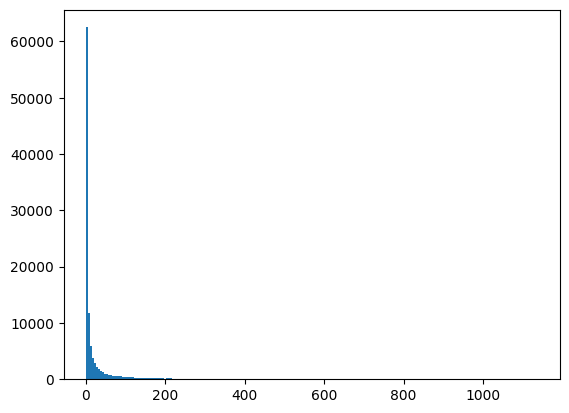

In [18]:
#redo hist plot without the outliers and look at distribution
df_us_users_valid = df_us_users[df_us_users.nbr_ratings < quantile]
print(df_us_users_valid.shape)
binwidth = 5
plt.hist(df_us_users_valid.nbr_ratings, bins=range(min(df_us_users_valid.nbr_ratings), max(df_us_users_valid.nbr_ratings) + binwidth, binwidth))
pass
#looks like an exponential distribution

### Second aproache

476.5692349930866
3522
0.9688932460719112


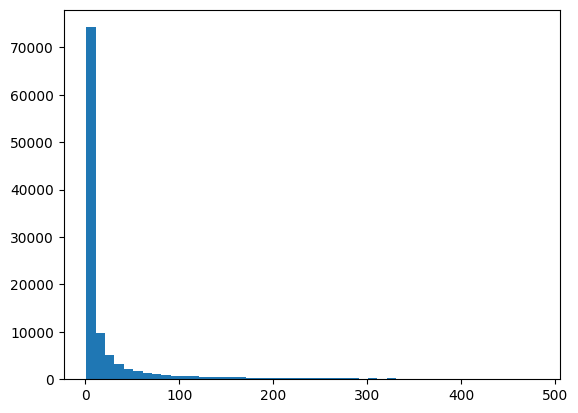

In [19]:
#if we remove outliers according to boxplot definition

outlier_value = df_us_users.nbr_ratings.mean() + 1.5*df_us_users.nbr_ratings.std()
print(outlier_value)
df_us_outliers = df_us_users[df_us_users.nbr_ratings > outlier_value]
print(df_us_outliers.shape[0])

df_us_users_valid2 = df_us_users[df_us_users.nbr_ratings < outlier_value]
nb_us_users_valid2 = df_us_users_valid2.shape[0]
print(nb_us_users_valid2/nb_us_users)
#97 percent of the us users have less than 476 ratings

df_us_users_valid2.nbr_ratings.describe()

binwidth = 10
plt.hist(df_us_users_valid2.nbr_ratings, bins=range(min(df_us_users_valid2.nbr_ratings), max(df_us_users_valid2.nbr_ratings) + binwidth, binwidth))
pass

### Third aproch

54957
0.4853872446411065
705.8764220912694
52702
0.4654707965696016
count    52702.000000
mean        71.598744
std        118.233750
min          5.000000
25%          9.000000
50%         21.000000
75%         72.000000
max        705.000000
Name: nbr_ratings, dtype: float64


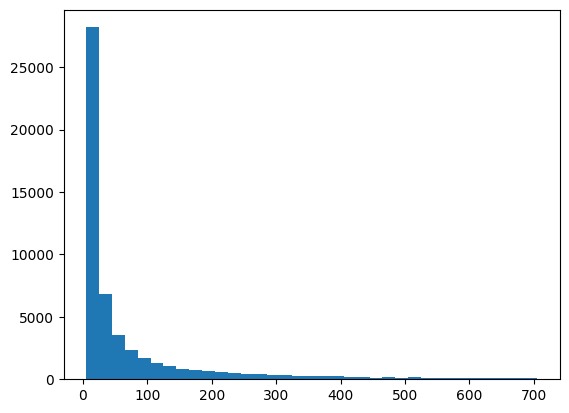

In [20]:
#many people only did less than 5 ratings, is this enough? -> valid user => over 5 ratings maybe?
lower = 5
df_us_users_lower = df_us_users[df_us_users.nbr_ratings >= lower]
#number of valid users and ratio
nb_valid_users_lower = df_us_users_lower.shape[0]
print(nb_valid_users_lower)
print(nb_valid_users_lower/nb_us_users)

outlier = df_us_users_lower.nbr_ratings.mean() + 1.5*df_us_users_lower.nbr_ratings.std()
print(outlier)
df_us_users_valid3 = df_us_users_lower[df_us_users_lower.nbr_ratings < outlier]
nb_us_users_valid3 = df_us_users_valid3.shape[0]
print(nb_us_users_valid3)
print(nb_us_users_valid3/nb_us_users)

print(df_us_users_valid3.nbr_ratings.describe())

binwidth = 20
plt.hist(df_us_users_valid3.nbr_ratings, bins=range(min(df_us_users_valid3.nbr_ratings), max(df_us_users_valid3.nbr_ratings) + binwidth, binwidth))
pass

### Valid user selection

In [21]:
#Question: what is the distribution of these ratings through time?
#How many ratings do we need to gather? still a lot

#How many ratings for all us_users?
print(df_us_users.nbr_ratings.sum(), "\n")

print(df_us_users_valid.nbr_ratings.sum())
print(df_us_users_valid2.nbr_ratings.sum())
print(df_us_users_valid3.nbr_ratings.sum())

7303870 

4874198
3147050
3773397


In [22]:
#In all cases (1-2-3, 3 different way to define 'valid'), we have a lot of valid users, 
#but we need to find a way to get read the large datafiles, total number of reviews is still large.


In [23]:
#ICI pas le meme nombre que la methode 0 (le truc tt en haut de la section) -> on prend quoi ? 

#define the users we will consider valid for our analysis
users_us_valid = set(df_us_users_valid3.user_name) 
len(users_us_valid)

52702

## Dataset reviews.txt.gz

This will be our main dataset. It contains the informations we want to build our datastory on.

However the compressed file is very large (1.6Gb), and loading the whole dataset directly into the RAM is not possible with our ressources. Moreover, the format used to store the data is not universal and is not supported by pandas reading functions.

We have adapted an helper function found ??? to parse the txt.gz file and return a generator. The generator is then used to recurively build the pandas dataframe.

In [24]:
def parse(filename):
    """
    Parse a txt.gz file and return a generator for it
    Copyright © 2017 Gael Lederrey <gael.lederrey@epfl.ch>
    :param filename: name of the file
    :return: Generator to go through the file
    """
    file = gzip.open(filename, 'rb')
    entry = {}
    # Go through all the lines
    for line in file:
        # Transform the string-bytes into a string
        line = line.decode("utf-8").strip()

        # We check for a colon in each line
        colon_pos = line.find(":")
        if colon_pos == -1:
            # if no, we yield the entry
            yield entry
            entry = {}
            continue
        # otherwise, we add the key-value pair to the entry
        key = line[:colon_pos]
        value = line[colon_pos + 2:]
        entry[key] = value

To build the dataframe, we have implemented a framwork that goes trought the generator and only keeps the desired column. We couldn't just load the whole dataset because some columns where too heavy for ours computers. We have also cast some of the columns to the right datatype to save some space (e.g. casting the column "beer_id" as an int is lighter than keeping it as a pandas object. 

In [25]:
gen = parse('./data_bier/beer_advocate/ratings.txt.gz')

In [26]:
# #REAL ?? 

# #General framework to load data from 'ratings.txt.gz'
# run = 1

# undesired_features = set(['text','review', 'brewery_name', 'brewery_id', 'user_id', 'beer_name'])

# if run == 1:

#     user_date_ls = []
#     full_ratings_ls = []


#     for idx, review in enumerate(gen):
#         #date_converted = datetime.datetime.fromtimestamp(int(review['date'])).strftime('%Y-%m-%d')
#         user_name = review['user_name']
#         valid_rows = [value for key, value in review.items() if key not in undesired_features]
#         if user_name in users_us_valid:
#             #user_date_ls.append((user_name,date_converted))
#             full_ratings_ls.append(valid_rows)
#         if (idx % 1000000 == 0):
#             print(idx)

    
#     df_user_date = pd.DataFrame(user_date_ls, columns = ['user','date'])
#     df_user_date.user = df_user_date.user.astype('string')
#     df_user_date.date = pd.to_datetime(df_user_date.date)

#     cols = [key for key, value in review.items() if key not in undesired_features]
#     df_ratings = pd.DataFrame(full_ratings_ls, columns = cols)
#     #try to save the dataframe for later reuse
#     df_user_date.to_pickle('/work/data/user_date_ba.pkl')
#     df_ratings.to_pickle('/work/data/ratings_ba.pkl')
# else : 
#     df_ratings = pd.read_pickle('/work/data/ratings_ba.pkl')

The dataframe is then saved in pickle format. 

In [27]:
#OR THIS ONE ?? 

#General framework to load data from 'ratings.txt.gz', set run = 1
run = 0

gen = parse('./data/ratings.txt.gz')
undesired_features = set(['text','review', 'brewery_name', 'brewery_id', 'user_id', 'beer_name'])

if run == 1:

    full_ratings_ls = []
    break_point = 4_000_000
    first_part = True
    second_part = False

    review = next(gen)
    cols = [key for key, value in review.items() if key not in undesired_features]

    int_cols = ['beer_id']
    float_cols = ['abv','appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    #string_cols = ['style', 'user_name']
    date_cols = ['date']

    for idx, review in enumerate(gen):
        user_name = review['user_name']
        valid_rows = [value for key, value in review.items() if key not in undesired_features]

        if second_part:
            if user_name in valid_us_users_names:
                full_ratings_ls.append(valid_rows)
            if (idx % 1000000 == 0):
                print(idx)

        if first_part:
            if user_name in valid_us_users_names:
                full_ratings_ls.append(valid_rows)
            if (idx % 1000000 == 0):
                print(idx)
            if (idx > break_point):
                df_ratings = pd.DataFrame(full_ratings_ls, columns = cols)

                df_ratings[int_cols] = df_ratings[int_cols].astype('int')
                df_ratings[float_cols] = df_ratings[float_cols].astype('float') 
                #df_ratings[string_cols] = df_ratings[string_cols].astype('string')

                df_ratings.date = pd.to_datetime(df_ratings.date.apply(lambda date : datetime.datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d')))

                df_ratings.to_pickle('./data_bier/our_data/first_file.pkl')

                full_ratings_ls = []
                first_part = False
                second_part = True

    df_ratings = pd.DataFrame(full_ratings_ls, columns = cols)

    df_ratings[int_cols] = df_ratings[int_cols].astype('int')
    df_ratings[float_cols] = df_ratings[float_cols].astype('float') 
    #df_ratings[string_cols] = df_ratings[string_cols].astype('string')

    df_ratings.date = pd.to_datetime(df_ratings.date.apply(lambda date : datetime.datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d')))

    df_ratings.to_pickle('./data_bier/our_data/ratings_us_ba_str.pkl')
else : 
    df_ratings = pd.read_pickle('./data_bier/our_data/ratings_us_ba_str.pkl')

In [28]:
df_ratings.head(5)

,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating
0,90101,Saison / Farmhouse Ale,6.2,2013-10-19,laxer8811,NaN,NaN,NaN,NaN,NaN,4.25
1,90101,Saison / Farmhouse Ale,6.2,2013-10-19,flayedandskinned,4.0,4.25,4.25,4.25,4.25,4.24
2,90101,Saison / Farmhouse Ale,6.2,2013-10-17,thugherman,NaN,NaN,NaN,NaN,NaN,4.50
3,90101,Saison / Farmhouse Ale,6.2,2013-10-15,claaark13,NaN,NaN,NaN,NaN,NaN,4.50
4,90101,Saison / Farmhouse Ale,6.2,2013-10-15,pknyc,NaN,NaN,NaN,NaN,NaN,3.75


We can now perfom some analysis to explore the data. 

### Ratings

We want to see how much rating they is in each beer category

To do so, we first have to add a column where each style is mapped to its parents beer style.

In [87]:

beers_id_cat = df_beers[['beer_id', 'category']]
df_ratings_cat = pd.merge(df_ratings, beers_id_cat, on = 'beer_id')

if False:
    df_ratings_cat.to_pickle("./data/df_ratings_cat.pkl")
if False:
    df_ratings_cat = pd.read_pickle("./data/df_ratings_cat.pkl")

In [90]:
print(df_ratings_cat[["style", "category"]].sample(3))


#We have 15 unique categegories, as expected
print("number of category : ", df_ratings_cat.category.nunique())

                       style     category
2212735  American Barleywine  Strong Ales
809961    American Brown Ale   Brown Ales
449081          Scottish Ale    Dark Ales
number of category :  15


<AxesSubplot:xlabel='category'>

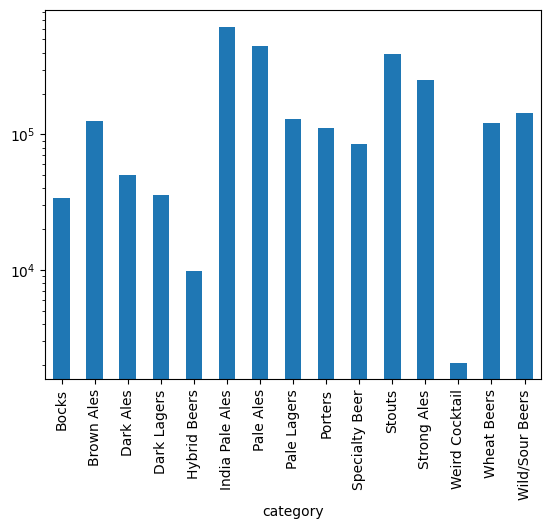

In [30]:
#Distribution of all ratings on the website!
df_category_cnt = df_ratings_cat.groupby('category').rating.count()
df_category_cnt.plot(kind = 'bar', logy = True)

### Ratings over time

Fist, we will look at the distribution of all the ratings of the valid user over time. 

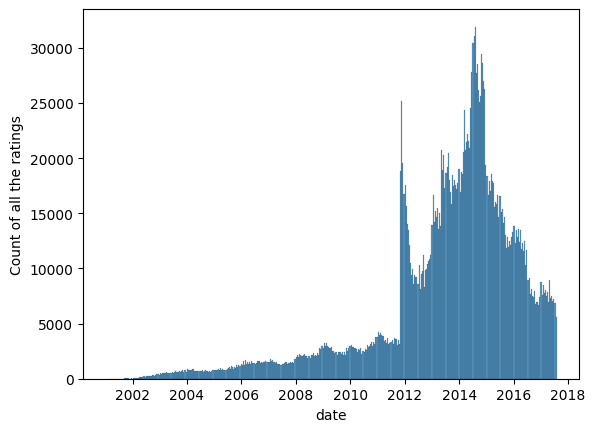

In [31]:
fig, ax1 = plt.subplots()
sns.histplot(df_ratings.date)
ax1.set_xlabel('date')
ax1.set_ylabel('Count of all the ratings')
plt.show()

Then we are also intersted in finding the first rating of each user (i.e. thier joining date)

In [32]:
first_rating_per_user=df_ratings.groupby(['user_name']).apply(lambda group : group.date.min())

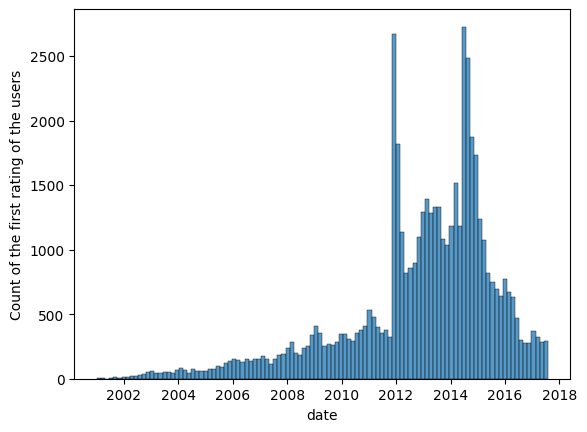

In [33]:
fig, ax1 = plt.subplots()
sns.histplot(first_rating_per_user)
ax1.set_xlabel('date')
ax1.set_ylabel('Count of the first rating of the users')
plt.show()

In both case, there is a huge spike in 2012. We did some researched, and apparently, beerAdvocate had a data breach in this period. We dont think that this will be a probleme for our analysis thought. 

#WHY ??

### ratings of each category of beer over time

We want to see how each category of beer evolves over time. We will plot the number of rating per category over time.

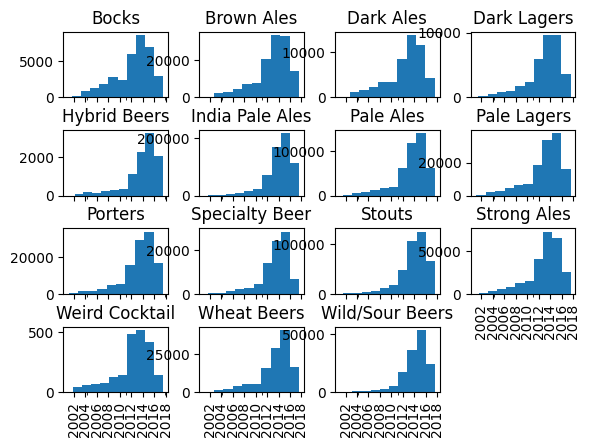

In [58]:
#time serie of each beer /!\ the y axis is NOT the same 
df_ratings_cat["date"].hist(by=df_ratings_cat["category"], sharex=True, sharey=False)
pass

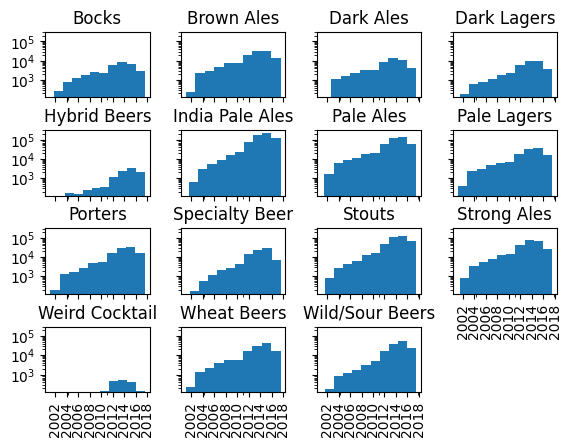

In [59]:
#the same graph, with a log scale and shared y-axis
df_ratings_cat["date"].hist(by=df_ratings_cat["category"], sharex=True, sharey=True, log = True)
pass

These plot are hardly readable, and even less comparable. It would be better to plot everything on a same graph. This required that we normalize each category by the total number of ratings in a chosen timeframe. Here, we choose to look at the distribution considering bins of one year.

In [63]:
#here we count how much ratings each category recieved for each year
cat_year = df_ratings_cat.groupby([pd.Grouper(freq="Y", key="date"), "category"])["beer_id"].count().reset_index()
print(cat_year.sample(3))
print(cat_year.shape)

          date     category  beer_id
149 2011-12-31        Bocks     2477
96  2007-12-31  Pale Lagers     2750
135 2010-12-31   Brown Ales     4611
(254, 3)


In [64]:
#Total number of ratings per year
review_year = cat_year.groupby("date").sum().reset_index()
print(review_year.sample(3))
print(review_year.shape)

         date  beer_id
10 2011-12-31   158374
0  2001-12-31      335
1  2002-12-31     5379
(17, 2)


In [65]:
#For each row (i.e. beer category over one year), we want to have both the number of ratings of
# the category and the total number of ratings over all the category over the year.
merge_data=cat_year.merge(review_year, left_on="date", right_on="date")
merge_data['ratio']=merge_data["beer_id_x"]/merge_data["beer_id_y"]
print(merge_data.sample(3))
merge_data.shape

          date      category  beer_id_x  beer_id_y     ratio
202 2014-12-31       Porters      24984     619684  0.040317
48  2004-12-31  Hybrid Beers        116      18329  0.006329
127 2009-12-31       Porters       3254      66040  0.049273


(254, 5)

In [66]:
#Each style over the whole period is grouped in a list of list
hists = []
for cat in merge_data["category"].unique():
    hists.append(merge_data.ratio[merge_data["category"]==cat].to_list())

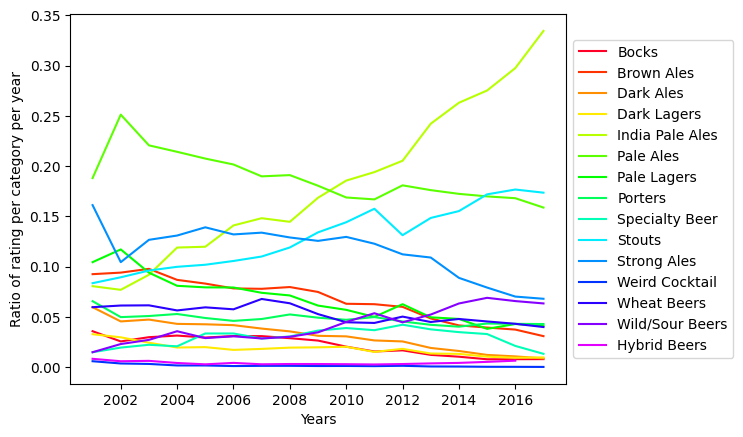

In [67]:
x = range(2001,2018)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])
i=0
for hist in hists:
    ax.plot(x[0:len(hist)],hist, label=merge_data["category"].unique()[i])
    i+=1

plt.xlabel("Years")
plt.ylabel("Ratio of rating per category per year")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The final graph gives us much informations. It shows for each year, the percentage of ratings that each style of beer got.

In 2017, 35% of the ratings are of IPAs !
we can clearly see the rise of popularity for the IPAs and Stouts, it will be important to take this into account when evaluating the evolution on a single user.


### User's 5 first and last ratings

Since we want to investigate the evolution of the user's taste over time, it would be interesting to see with wich beer the user "started" and "ended".

 We will look at the distribution of each beer category over the five first ratings of all the users. In other words, beers which category will the user rate first.

In [41]:
df_ratings_cat.head(1)

,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating,category
0,90101,Saison / Farmhouse Ale,6.2,2013-10-19,laxer8811,NaN,NaN,NaN,NaN,NaN,4.25,Pale Ales


# a partir de la j'ai juste copier le code, peut tre quon peut epurer

In [42]:
def first_ratings_user(ratings, first = 5, last = 5):
    ratings_sorted = ratings.sort_values(by = 'date')
    first_ratings = ratings_sorted[:first]
    last_ratings = ratings_sorted[-last:]
    first_categories = list(set(first_ratings.category))
    last_categories = list(set(last_ratings.category))
    return first_categories, last_categories

In [43]:

#SLOW
df_first = df_ratings_cat[['user_name', 'date', 'category']]
df_first = df_first.groupby('user_name').apply(lambda user_rating: pd.Series({'first_last_cats' : first_ratings_user(user_rating)})).reset_index()
df_first['first_cats'] = df_first['first_last_cats'].apply(lambda cats: cats[0])
df_first['last_cats'] = df_first['first_last_cats'].apply(lambda cats: cats[1])
df_first = df_first.drop(['first_last_cats'], axis = 1)

In [44]:
#Try to check if some categories (dis)appear between the first 5 and the last 5 ratings

df_first['nb_cat_first'] = df_first['first_cats'].apply(lambda cat: len(cat))
df_first['nb_cat_last'] = df_first['last_cats'].apply(lambda cat: len(cat))
df_first.head(5)

,user_name,first_cats,last_cats,nb_cat_first,nb_cat_last
0,--Dom--,"[India Pale Ales, Stouts, Strong Ales]","[India Pale Ales, Pale Lagers]",3,2
1,-BobWeaver-,[India Pale Ales],[India Pale Ales],1,1
2,-MK-,"[India Pale Ales, Stouts, Wheat Beers, Dark La...","[India Pale Ales, Bocks]",4,2
3,-NESTO-,"[Pale Ales, Stouts, Wheat Beers, Strong Ales]","[Pale Ales, Stouts, Wild/Sour Beers]",4,3
4,-Rick,"[India Pale Ales, Stouts]","[Stouts, Wild/Sour Beers]",2,2


#### User diverity in the 5 first ratings

Text(0.5, 1.0, 'How many different categories valid users mention in their first 5 ratings')

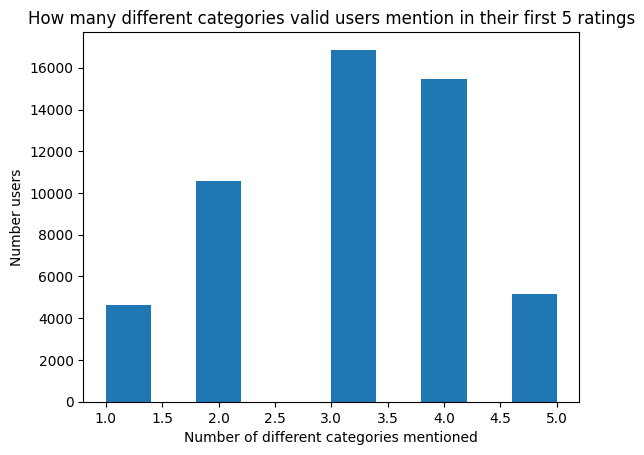

In [45]:
plt.hist(df_first.nb_cat_first)
plt.xlabel('Number of different categories mentioned')
plt.ylabel('Number users')
plt.title('How many different categories valid users mention in their first 5 ratings')

Text(0.5, 1.0, 'How many different categories valid users mention in their last 5 ratings')

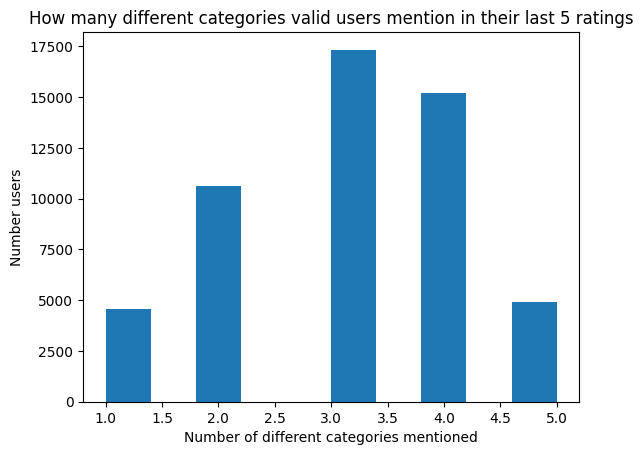

In [46]:
plt.hist(df_first.nb_cat_last)
plt.xlabel('Number of different categories mentioned')
plt.ylabel('Number users')
plt.title('How many different categories valid users mention in their last 5 ratings')

#### Wich category dominated

In [47]:
first_categories = df_first['first_cats']
last_categories = df_first['last_cats']

In [48]:
def category_counter(categories):
    mydict = {}
    for first_categories in categories:
        for cat in first_categories:
            if cat in mydict.keys():
                mydict[cat] += 1
            else:
                mydict[cat] = 1 
    return mydict

In [49]:
first_categories_dict = category_counter(first_categories)
last_categories_dict = category_counter(last_categories)
first_categories_dict

{'India Pale Ales': 31945,
 'Stouts': 21805,
 'Strong Ales': 17720,
 'Wheat Beers': 10162,
 'Dark Lagers': 4332,
 'Pale Ales': 26331,
 'Wild/Sour Beers': 5402,
 'Brown Ales': 11050,
 'Pale Lagers': 10582,
 'Weird Cocktail': 360,
 'Porters': 8556,
 'Specialty Beer': 6925,
 'Bocks': 3530,
 'Dark Ales': 4679,
 'Hybrid Beers': 678}

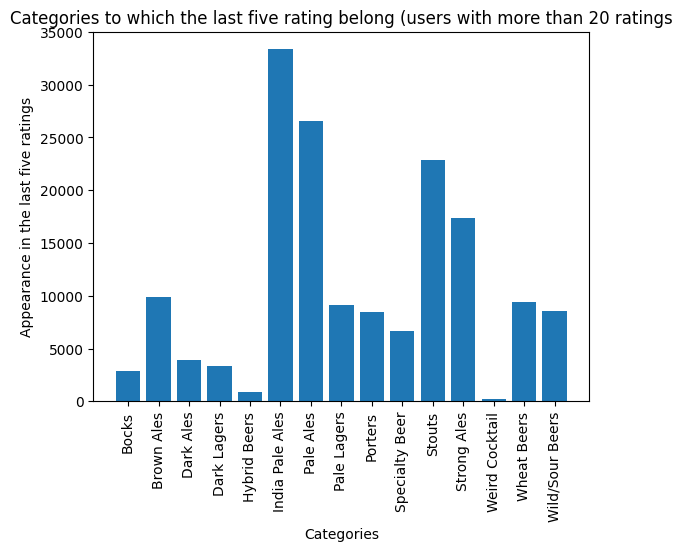

In [50]:
#General distribution of the last five ratings!

vals = []
for cat, count in last_categories_dict.items():
    vals.append((cat,count))
vals = sorted(vals, key = lambda tup: tup[0])

cat_last = []
count_last = []

for val in vals:
    cat_last.append(val[0])
    count_last.append(val[1])

plt.bar(cat_last, count_last)
plt.xlabel('Categories')
plt.xticks(rotation = 90)
plt.ylabel('Appearance in the last five ratings')
plt.title("Categories to which the last five rating belong (users with more than 20 ratings")
pass

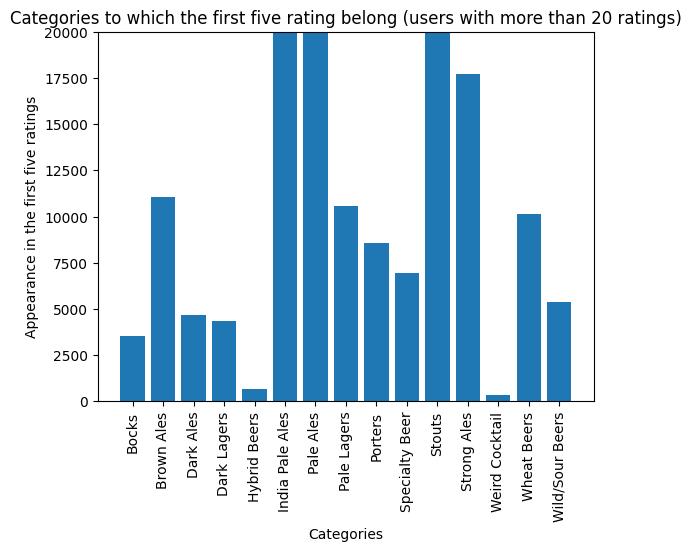

In [51]:
#General distribution of the five first ratings!

vals = []
for cat, count in first_categories_dict.items():
    vals.append((cat,count))
vals = sorted(vals, key = lambda tup: tup[0])

cat_first = []
count_first = []

for val in vals:
    cat_first.append(val[0])
    count_first.append(val[1])

plt.bar(cat_first, count_first)
plt.xlabel('Categories')
plt.xticks(rotation = 90)
plt.ylim(0,20000)
plt.ylabel('Appearance in the first five ratings')
plt.title("Categories to which the first five rating belong (users with more than 20 ratings)")
pass


Below, the percentage of change between 5 first and 5 last beers. We see some clear change, but is it due to a global trend ? And how to know that ? 

In [52]:
change_percentage = []
for count_f, count_l in zip(count_first,count_last):
    change_percentage.append((count_l-count_f)/count_f)
df_percentage = pd.DataFrame(change_percentage, cat_first)
df_percentage

,0
Bocks,-0.192635
Brown Ales,-0.106063
Dark Ales,-0.165634
Dark Lagers,-0.236380
Hybrid Beers,0.253687
India Pale Ales,0.043919
Pale Ales,0.007368
Pale Lagers,-0.135986
Porters,-0.008883
Specialty Beer,-0.040000
